# Visualize Caustics

Here we will demonstrate how to collect caustic lines using caustic! Since caustic (the code) uses autodiff and can get exact derivatives, it is actually very accurate at computing caustics. 

Conceptually a caustic occurs where the magnification of a lens diverges to infinity. A convenient way to measure the magnification in the image plane is by taking the determinant ($det$) of the jacobian of the lens equation ($A$), its reciprocal is the magnification. This means that anywhere that $det(A) = 0$ is a critical line in the image plane (magnification goes to infinity). If we take this line and raytrace it back to the source plane we can see the caustics which define boundaries for lensing phenomena.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np
from time import process_time as time

import caustics

In [2]:
# initialization stuff for an SIE lens

cosmology = caustics.cosmology.FlatLambdaCDM(name="cosmo")
cosmology.to(dtype=torch.float32)
sie = caustics.lenses.SIE(cosmology, name="sie")
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustics.utils.get_meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    upsample_factor * n_pix,
    dtype=torch.float32,
)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
x = torch.tensor(
    [
        z_l.item(),  # sie z_l
        0.0,  # sie x0
        0.0,  # sie y0
        0.4,  # sie q
        np.pi / 5,  # sie phi
        1.0,  # sie b
    ]
)
packparams = sie.pack(x)

## Critical Lines

Before we can see the caustics, we need to find the critical lines. The critical lines are the locus of points in the lens plane (the plane of the mass causing the lensing) at which the magnification of the source becomes theoretically infinite for a point source. In simpler terms, it is where the lensing effect becomes so strong that it can create highly magnified and distorted images of the source. The shape and size of the critical curve depend on the distribution of mass in the lensing object. These lines can be found using the Jacobian of the lensing deflection, specifically $A = \mathbb{I} - J$. When ${\rm det}(A) = 0$, that point is on the critical line. Interestingly, $\frac{1}{{\rm det}(A)}$ is the magnification, which is why ${\rm det}(A) = 0$ defines the points of infinite magnification.

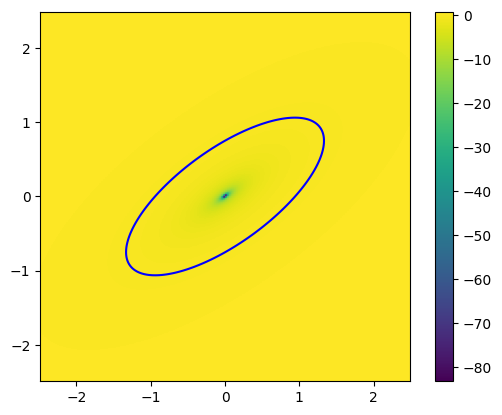

In [3]:
# Conveniently caustic has a function to compute the jacobian of the lens equation
A = sie.jacobian_lens_equation(thx, thy, z_s, packparams)
# Note that if this is too slow you can set `method = "finitediff"` to run a faster version. You will also need to provide `pixelscale` then

# Here we compute A's determinant at every point
detA = torch.linalg.det(A)

# Plot the critical line
im = plt.imshow(
    detA, extent=(thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin="lower"
)
plt.colorbar(im)
CS = plt.contour(thx, thy, detA, levels=[0.0], colors="b")

plt.show()

## Caustics

Critical lines show us where the magnification approaches infinity, they are important structures in understanding a lensing system. These lines are also very useful when mapped into the source plane. When the critical lines are raytraced back to the source plane they are called caustics (see what we did there?). In the source plane these lines deliniate when a source will be multiply imaged. 

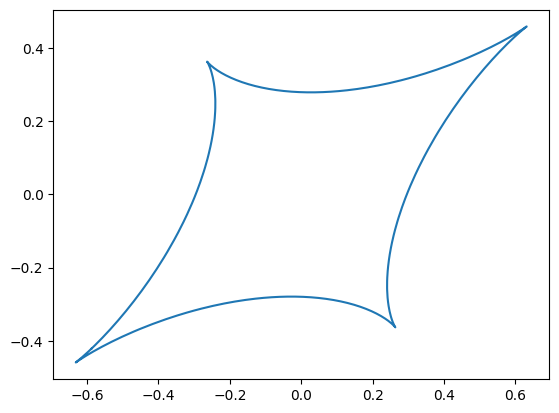

In [4]:
# Get the path from the matplotlib contour plot of the critical line
paths = CS.allsegs[0]

for path in paths:
    # Collect the path into a discrete set of points
    x1 = torch.tensor(list(float(vs[0]) for vs in path))
    x2 = torch.tensor(list(float(vs[1]) for vs in path))
    # raytrace the points to the source plane
    y1, y2 = sie.raytrace(x1, x2, z_s, packparams)

    # Plot the caustic
    plt.plot(y1, y2)
plt.show()